In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from util import *

# set path to data folder
root = "F:/Studium/Master/semester5/thesis/data/dataset/"

# definition of the true positive species zymoMock
species_zymo_mock = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}

# definition of the true positive species zymoOral
species_zymo_oral = {
    "Streptococcus parasanguinis",
    "Veillonella parvula",
    "Neisseria subflava",
    "Prevotella nigrescens",
    "Streptococcus mitis",
    "Haemophilus parainfluenzae",
    "Schaalia odontolytica",
    "Rothia dentocariosa",
    "Streptococcus salivarius",
    "Fusobacterium nucleatum",
    "Streptococcus mutans",
    "Porphyromonas gingivalis"}

# total read count in zymoMock dataset
total_zymo_mock = 1_160_526
# total read count in zymoOral dataset
total_zymo_oral = 1_140_052
# reading the taxonomic tree
tree = Tree(root + "tree_nr.txt")
# generate dictionary with all taxa that are true positives for each taxonomic rank
true_taxons_zymo_mock = get_true_taxons_for_all_ranks(tree, species_zymo_mock)
true_taxons_zymo_oral = get_true_taxons_for_all_ranks(tree, species_zymo_oral)

In [6]:
# read table with paths to datasets and metadata
data_zymo_mock_metadata = pd.read_csv("datasets_zymo_mock_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_mock = pd.DataFrame()
for i, row in data_zymo_mock_metadata.iterrows():
    # filter out other k-mer sizes
    if row["kmer size"] != 13 or row["alphabet"] != "Uniform11S" or row["filtering"] != "c > 3" or row["database"] != "NR90":
        continue
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_mock)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_mock)
    per_taxon_assignment["seed shape"] = row["seed shape"]
    data_zymo_mock = pd.concat([data_zymo_mock, per_taxon_assignment], ignore_index=True, axis=0)
data_zymo_mock

true positive,rank,false positive,true positive,precision,recall,seed shape
0,class,29643.0,1011456.0,0.971527,0.871550,consecutive
1,family,27444.0,984835.0,0.972889,0.848611,consecutive
2,genus,54708.0,853055.0,0.939733,0.735059,consecutive
3,kingdom,2827.0,1083841.0,0.997398,0.933922,consecutive
4,order,21338.0,998320.0,0.979073,0.860231,consecutive
5,phylum,19602.0,1037336.0,0.981454,0.893850,consecutive
6,species,103198.0,493935.0,0.827178,0.425613,consecutive
7,superkingdom,723.0,1119180.0,0.999354,0.964373,consecutive
8,class,38281.0,920392.0,0.960069,0.793082,Choi
9,family,31310.0,890281.0,0.966026,0.767136,Choi


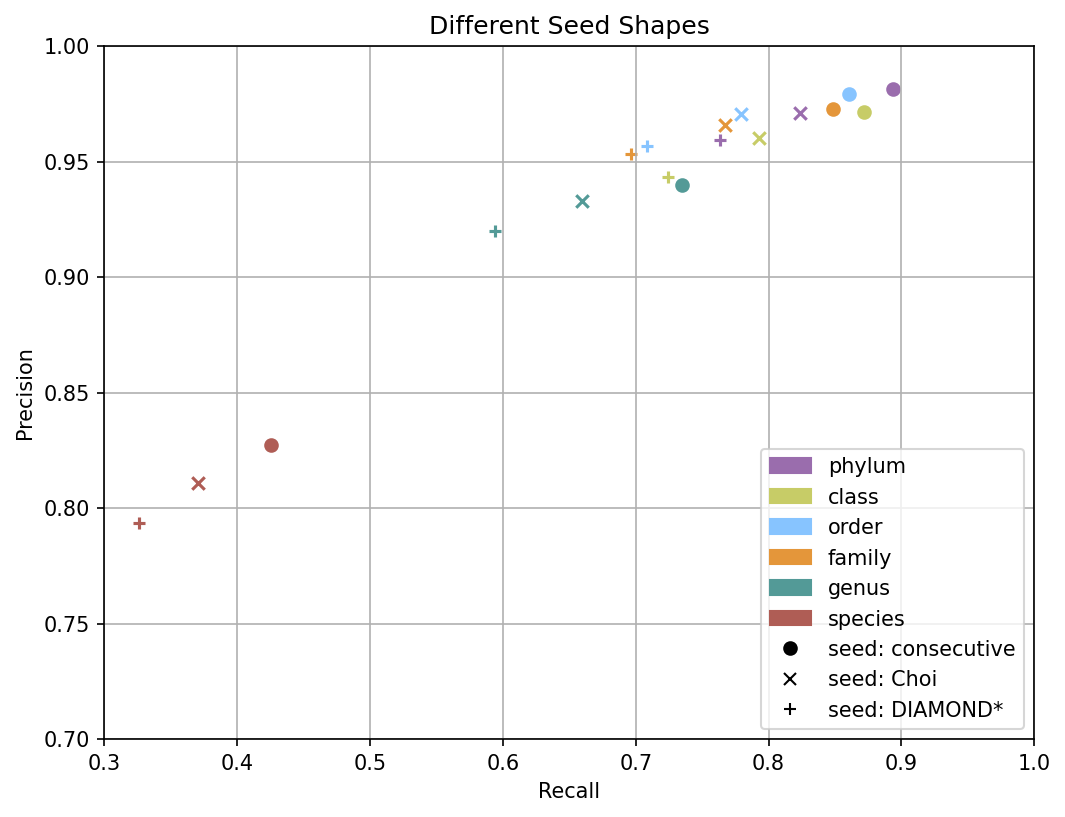

In [8]:
ranks = ["phylum", "class", "order", "family", "genus", "species"]
colors = ["#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
markers = ["o", "x", "+"]

# creating legends
handles_colors = []
handles_symbols = []

plt.figure(figsize=(8, 6), dpi=150)
plt.grid()
for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    handles_symbols = []
    for marker, seed_shape in zip(markers, data_zymo_mock["seed shape"].unique()):
        handles_symbols.append(Line2D([], [], marker=marker, color="black", label="seed: " + str(seed_shape), linestyle="None"))
        data_filtered = data_zymo_mock[(data_zymo_mock["rank"] == rank) & (data_zymo_mock["seed shape"] == seed_shape)]
        plt.scatter(data_filtered["recall"], data_filtered["precision"], label=rank, color=color, marker=marker)

plt.xlim(0.3, 1)
plt.ylim(0.7, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Different Seed Shapes")

plt.legend(handles=handles_colors + handles_symbols, loc="lower right")
plt.show()

In [9]:
data_zymo_oral_metadata = pd.read_csv("datasets_zymo_oral_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_oral = pd.DataFrame()
for i, row in data_zymo_oral_metadata.iterrows():
    # filter out other k-mer sizes
    if row["kmer size"] != 13 or row["alphabet"] != "Uniform11S" or row["filtering"] != "c > 3" or row["database"] != "NR90":
        continue
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_oral)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_oral)
    per_taxon_assignment["seed shape"] = row["seed shape"]
    data_zymo_oral = pd.concat([data_zymo_oral, per_taxon_assignment], ignore_index=True, axis=0)
data_zymo_oral

true positive,rank,false positive,true positive,precision,recall,seed shape
0,class,8678.0,1128596.0,0.992369,0.989951,consecutive
1,family,13358.0,1119989.0,0.988214,0.982402,consecutive
2,genus,21525.0,1107578.0,0.980936,0.971515,consecutive
3,kingdom,213.0,1131999.0,0.999812,0.992936,consecutive
4,order,12191.0,920979.0,0.986936,0.807839,consecutive
5,phylum,143.0,1137331.0,0.999874,0.997613,consecutive
6,species,552584.0,449498.0,0.448564,0.394279,consecutive
7,superkingdom,1432.0,1138301.0,0.998744,0.998464,consecutive
8,class,2180.0,1131917.0,0.998078,0.992864,Choi
9,family,6384.0,1122864.0,0.994347,0.984923,Choi


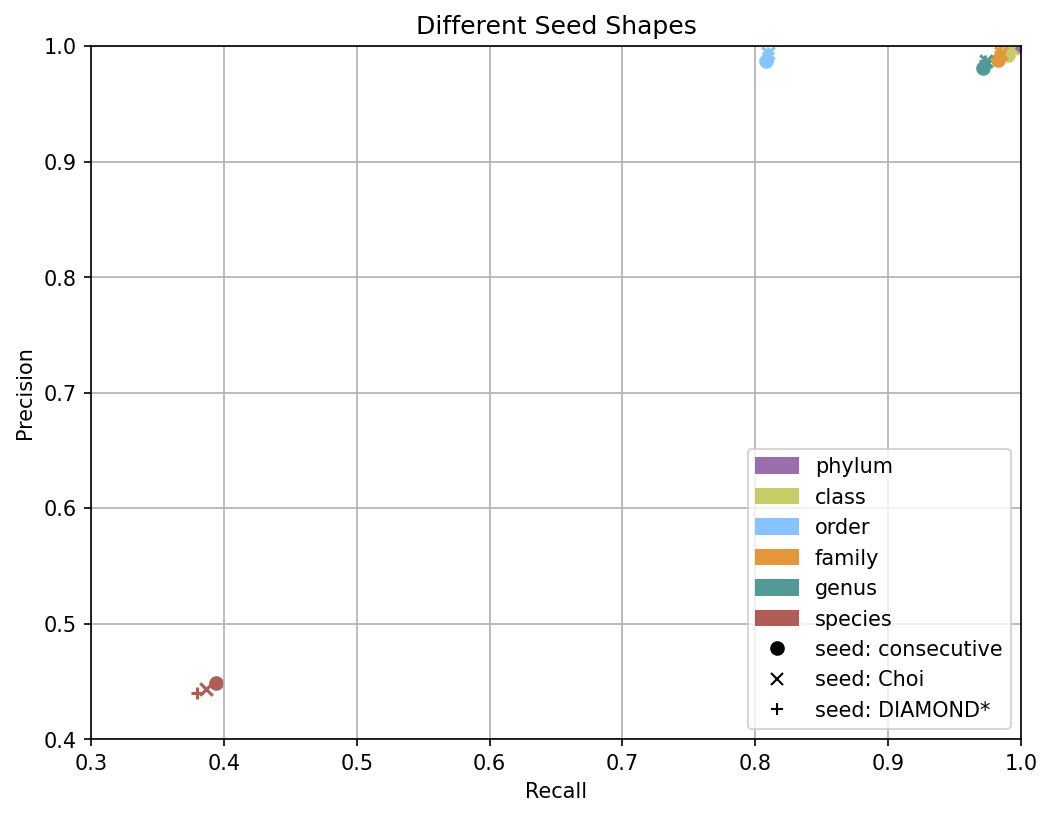

In [12]:
ranks = ["phylum", "class", "order", "family", "genus", "species"]
colors = ["#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
markers = ["o", "x", "+"]

# creating legends
handles_colors = []
handles_symbols = []

plt.figure(figsize=(8, 6), dpi=150)
plt.grid()
for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    handles_symbols = []
    for marker, seed_shape in zip(markers, data_zymo_oral["seed shape"].unique()):
        handles_symbols.append(Line2D([], [], marker=marker, color="black", label="seed: " + str(seed_shape), linestyle="None"))
        data_filtered = data_zymo_oral[(data_zymo_oral["rank"] == rank) & (data_zymo_oral["seed shape"] == seed_shape)]
        plt.scatter(data_filtered["recall"], data_filtered["precision"], label=rank, color=color, marker=marker)

plt.xlim(0.3, 1)
plt.ylim(0.4, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Different Seed Shapes")

plt.legend(handles=handles_colors + handles_symbols, loc="lower right")
plt.show()